In [1]:
import torch
from torch.utils.data import DataLoader
from torch.optim import AdamW, SGD 


import json


from statistics import mean

In [2]:
import utils_generic as generic
import st_dep as st
import model_confs as confs


import train_datamaps_inprogress as train

from train import eval_func

In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [4]:
model_conf = confs.distilbert_conf
encoding_type = 'pos'
model_name = 'distilbert'

# Datos ConvAI2

In [5]:
with open('Datasets\ConvAI2\convai2_complete.json','r') as f:
    data = json.load(f)

In [6]:
vocab = generic.Vocabulary(data['train'],encoding_type)

In [7]:
convai_train = data['train']
convai_val = data['validation']



convai_train_token = generic.tokenize_dataset_with_dependencies(convai_train,['about','to','as'],vocab,model_conf) 
convai_val_token = generic.tokenize_dataset_with_dependencies(convai_val,['about','to','as'],vocab,model_conf) 

In [8]:
convai_train_dataset = {}
for task in ['to','as','about']:
    convai_train_dataset[task] = st.DatasetSingleTaskDep(convai_train_token,task,eval=False)

In [9]:
convai_val_dataset = {}
for task in ['to','as','about']:
    convai_val_dataset[task] = st.DatasetSingleTaskDep(convai_val_token,task,eval=False)

# Datos md_gender

In [10]:
with open('Datasets\md_gender\md_complete.json','r',encoding="utf8") as f:
    md_data = json.load(f)

In [11]:
md_tokenized = generic.tokenize_dataset_with_dependencies(md_data,['about','to','as'],vocab,model_conf) 


md_dataset = {}
for task in ['to','as','about']:
    md_dataset[task] = st.DatasetSingleTaskDep(md_tokenized,task,eval=True)

# Creación dataloaders

In [12]:
dl_train = {}
for task in ['to','as','about']:
    dl_train[task] = DataLoader(convai_train_dataset[task],batch_size=128,shuffle=True,collate_fn=st.collate_fn)

In [13]:
dl_val = {}
for task in ['to','as','about']:
    dl_val[task] = DataLoader(convai_val_dataset[task],batch_size=128,shuffle=True,collate_fn=st.collate_fn)

In [14]:
dl_eval = {}
for task in ['to','as','about']:
    dl_eval[task] = DataLoader(md_dataset[task],batch_size=128,shuffle=False,collate_fn=st.collate_fn)

# ABOUT

In [15]:
learning_rate = 1e-6
num_epochs = 100

global_metrics = {'about':{'recall':{'average':[],'female':[],'male':[]},
                            'precision':{'average':[],'female':[],'male':[]},
                            'f1':{'average':[],'female':[],'male':[]},
                            'acc':[]},
                    'to':{'recall':{'average':[],'female':[],'male':[]},
                            'precision':{'average':[],'female':[],'male':[]},
                            'f1':{'average':[],'female':[],'male':[]},
                            'acc':[]},
                    'as':{'recall':{'average':[],'female':[],'male':[]},
                            'precision':{'average':[],'female':[],'male':[]},
                            'f1':{'average':[],'female':[],'male':[]},
                            'acc':[]}}

In [16]:
model = st.SingleTaskDep(model_conf,vocab,num_labels=2).to(device)
save_path=f'{model_name}_{encoding_type}_about'

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_projector.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.5867003186343024 	 Validation loss: 0.4388244162171574 	 
  1%|          | 574/57400 [02:42<3:47:46,  4.16it/s]
Epoch 2 	 Training loss: 0.40690149143597804 	 Validation loss: 0.36753611544431264 	 
  2%|▏         | 1148/57400 [05:08<3:54:56,  3.99it/s]
Epoch 3 	 Training loss: 0.36178053064005716 	 Validation loss: 0.34604911076820505 	 
  3%|▎         | 1722/57400 [07:34<3:38:38,  4.24it/s]
Epoch 4 	 Training loss: 0.34060429501305056 	 Validation loss: 0.33549013001433875 	 
  4%|▍         | 2296/57400 [09:57<3:39:08,  4.19it/s]
Epoch 5 	 Training loss: 0.32664863388816656 	 Validation loss: 0.32831242781574443 	 
  5%|▌         | 2870/57400 [12:49<4:37:10,  3.28it/s]
Epoch 6 	 Training loss: 0.3161888294155589 	 Validation loss: 0.32171088027752054 	 
  6%|▌         | 3444/57400 [16:08<5:30:18,  2.72it/s]
Epoch 7 	 Training loss: 0.30561070149368524 	 Validation loss: 0.31797847985211064 	 
  7%|▋         | 4018/57400 [19:17<3:31:20,  4.21it/s]
Epoch 8 	 

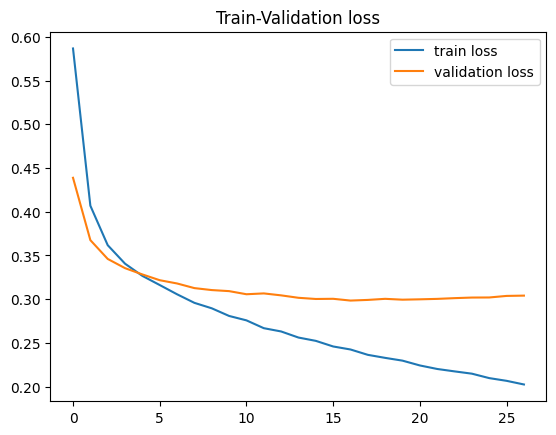

In [17]:
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
p = train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path,es_threshold=0)
torch.save(p,save_path+'.pt')

In [18]:
model = st.SingleTaskDep(model_conf,vocab,num_labels=2).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
    print('\n')
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = eval_func(model,dl_eval[task])
    for metric, value in metric_result.items():
        if metric=='accuracy':
            global_metrics[task]['acc'].append(value) 
        else:
            for g,v in value.items():
                global_metrics[task][metric][g].append(v)

        print(metric,metric_result[metric])


Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_projector.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).




Evaluación en el conjunto el conjunto about
recall {'female': 0.8275, 'male': 0.84375, 'average': 0.8356250000000001}
precision {'female': 0.8465473145780051, 'male': 0.8244274809160306, 'average': 0.8354873977470179}
f1 {'female': 0.8369152970922882, 'male': 0.8339768339768341, 'average': 0.8354460655345611}
accuracy 0.8354591836734694


Evaluación en el conjunto el conjunto to
recall {'female': 0.6456692913385826, 'male': 0.6861313868613139, 'average': 0.6659003390999483}
precision {'female': 0.656, 'male': 0.6762589928057554, 'average': 0.6661294964028777}
f1 {'female': 0.6507936507936508, 'male': 0.6811594202898551, 'average': 0.665976535541753}
accuracy 0.6666666666666666


Evaluación en el conjunto el conjunto as
recall {'female': 0.7223719676549866, 'male': 0.6540404040404041, 'average': 0.6882061858476953}
precision {'female': 0.6617283950617284, 'male': 0.7154696132596685, 'average': 0.6885990041606984}
f1 {'female': 0.6907216494845362, 'male': 0.6833773087071241, 'average':

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_projector.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.538749558013906 	 Validation loss: 0.3994184489977562 	 
  1%|          | 574/57400 [02:58<5:00:06,  3.16it/s]
Epoch 2 	 Training loss: 0.3763112496675515 	 Validation loss: 0.3501982822761697 	 
  2%|▏         | 1148/57400 [05:23<3:49:05,  4.09it/s]
Epoch 3 	 Training loss: 0.3440620493182737 	 Validation loss: 0.3356976743976949 	 
  3%|▎         | 1722/57400 [08:34<4:21:30,  3.55it/s]
Epoch 4 	 Training loss: 0.3257862649312833 	 Validation loss: 0.32647825019844506 	 
  4%|▍         | 2296/57400 [12:20<5:10:18,  2.96it/s]
Epoch 5 	 Training loss: 0.3139412401808679 	 Validation loss: 0.32274719996977663 	 
  5%|▌         | 2870/57400 [15:17<4:37:18,  3.28it/s]
Epoch 6 	 Training loss: 0.30390008969900917 	 Validation loss: 0.31529098041987014 	 
  6%|▌         | 3444/57400 [18:07<4:22:28,  3.43it/s]
Epoch 7 	 Training loss: 0.29464712933692366 	 Validation loss: 0.31125102937221527 	 
  7%|▋         | 4018/57400 [20:57<4:11:15,  3.54it/s]
Epoch 8 	 Traini

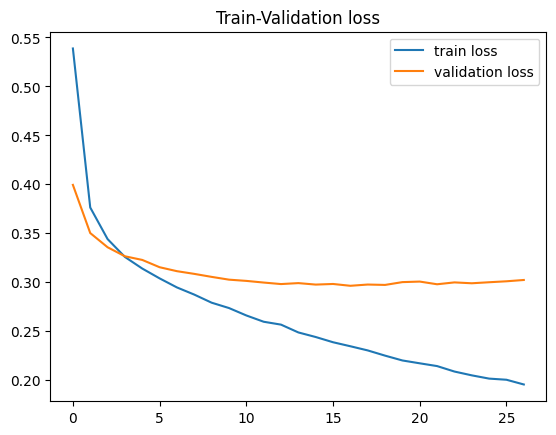

In [19]:
model = st.SingleTaskDep(model_conf,vocab,num_labels=2).to(device)
save_path=f'{model_name}_{encoding_type}_about2'

optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
p = train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path,es_threshold=0)
torch.save(p,save_path+'.pt')

In [20]:
model = st.SingleTaskDep(model_conf,vocab,num_labels=2).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
    print('\n')
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = eval_func(model,dl_eval[task])
    for metric, value in metric_result.items():
        if metric=='accuracy':
            global_metrics[task]['acc'].append(value) 
        else:
            for g,v in value.items():
                global_metrics[task][metric][g].append(v)

        print(metric,metric_result[metric])


Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_projector.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).




Evaluación en el conjunto el conjunto about
recall {'female': 0.8275, 'male': 0.8541666666666666, 'average': 0.8408333333333333}
precision {'female': 0.8552971576227391, 'male': 0.8261964735516373, 'average': 0.8407468155871882}
f1 {'female': 0.8411689961880559, 'male': 0.8399487836107554, 'average': 0.8405588898994056}
accuracy 0.8405612244897959


Evaluación en el conjunto el conjunto to
recall {'female': 0.6141732283464567, 'male': 0.6909975669099757, 'average': 0.6525853976282162}
precision {'female': 0.6481994459833795, 'male': 0.6589327146171694, 'average': 0.6535660803002745}
f1 {'female': 0.6307277628032345, 'male': 0.6745843230403801, 'average': 0.6526560429218073}
accuracy 0.6540404040404041


Evaluación en el conjunto el conjunto as
recall {'female': 0.6792452830188679, 'male': 0.6742424242424242, 'average': 0.676743853630646}
precision {'female': 0.6614173228346457, 'male': 0.6917098445595855, 'average': 0.6765635836971156}
f1 {'female': 0.6702127659574468, 'male': 0.6828

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_projector.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.5810946544392184 	 Validation loss: 0.4214297376446805 	 
  1%|          | 574/57400 [02:59<3:41:11,  4.28it/s]
Epoch 2 	 Training loss: 0.39062818952346096 	 Validation loss: 0.35729482264842016 	 
  2%|▏         | 1148/57400 [05:34<5:24:14,  2.89it/s]
Epoch 3 	 Training loss: 0.3532885889610347 	 Validation loss: 0.3395506287530317 	 
  3%|▎         | 1722/57400 [08:24<4:19:08,  3.58it/s]
Epoch 4 	 Training loss: 0.33560113556916704 	 Validation loss: 0.3301700383929883 	 
  4%|▍         | 2296/57400 [11:13<4:29:41,  3.41it/s]
Epoch 5 	 Training loss: 0.320804914193494 	 Validation loss: 0.32267667630971486 	 
  5%|▌         | 2870/57400 [14:03<4:31:19,  3.35it/s]
Epoch 6 	 Training loss: 0.3112052676725471 	 Validation loss: 0.32048644251742603 	 
  6%|▌         | 3444/57400 [16:53<5:03:50,  2.96it/s]
Epoch 7 	 Training loss: 0.300087446587011 	 Validation loss: 0.31235914993084085 	 
  7%|▋         | 4018/57400 [19:49<4:25:32,  3.35it/s]
Epoch 8 	 Trainin

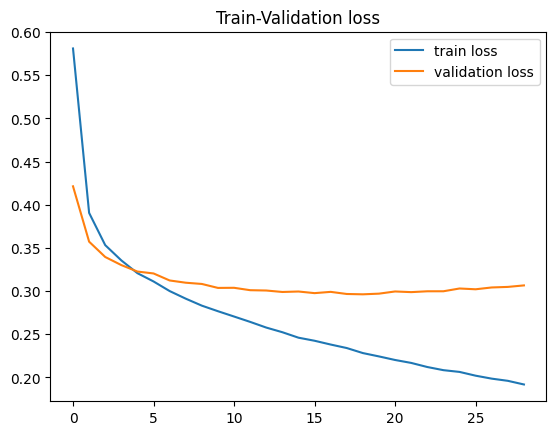

In [21]:
model =st.SingleTaskDep(model_conf,vocab,num_labels=2).to(device)
save_path=f'{model_name}_{encoding_type}_about3'

optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
p = train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path,es_threshold=0)
torch.save(p,save_path+'.pt')

In [22]:
model = st.SingleTaskDep(model_conf,vocab,num_labels=2).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
    print('\n')
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = eval_func(model,dl_eval[task])
    for metric, value in metric_result.items():
        if metric=='accuracy':
            global_metrics[task]['acc'].append(value) 
        else:
            for g,v in value.items():
                global_metrics[task][metric][g].append(v)

        print(metric,metric_result[metric])


Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_projector.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).




Evaluación en el conjunto el conjunto about
recall {'female': 0.84, 'male': 0.8411458333333334, 'average': 0.8405729166666667}
precision {'female': 0.8463476070528967, 'male': 0.834625322997416, 'average': 0.8404864650251563}
f1 {'female': 0.8431618569636135, 'male': 0.8378728923476005, 'average': 0.8405173746556069}
accuracy 0.8405612244897959


Evaluación en el conjunto el conjunto to
recall {'female': 0.6456692913385826, 'male': 0.683698296836983, 'average': 0.6646837940877828}
precision {'female': 0.6542553191489362, 'male': 0.6754807692307693, 'average': 0.6648680441898527}
f1 {'female': 0.6499339498018494, 'male': 0.6795646916565901, 'average': 0.6647493207292197}
accuracy 0.6654040404040404


Evaluación en el conjunto el conjunto as
recall {'female': 0.6981132075471698, 'male': 0.6742424242424242, 'average': 0.686177815894797}
precision {'female': 0.6675257731958762, 'male': 0.7044854881266491, 'average': 0.6860056306612627}
f1 {'female': 0.6824769433465085, 'male': 0.68903225

Resultados finales

In [23]:
for metric in ['f1','recall','precision']:
    print(f'{metric} medio de los 3 modelos: \n')
    for task in ['about','to','as']:
        print(task.upper())
        print(f'Resultado global {metric}:',mean(global_metrics[task][metric]['average']))
        print(f'{metric} etiqueta male:',mean(global_metrics[task][metric]['male']))
        print(f'{metric} etiqueta female: ',mean(global_metrics[task][metric]['female']))
        print('\n')

print(f'Accuracy medio de los 3 modelos: \n')
for task in ['about','to','as']:
    print('\n',task.upper())
    print('Resultado global accuracy:',mean(global_metrics[task]['acc']))

f1 medio de los 3 modelos: 

ABOUT
Resultado global f1: 0.8388407766965246
f1 etiqueta male: 0.8372661699783966
f1 etiqueta female:  0.8404153834146525


TO
Resultado global f1: 0.6611272997309267
f1 etiqueta male: 0.6784361449956084
f1 etiqueta female:  0.6438184544662449


AS
Resultado global f1: 0.6831142292813349
f1 etiqueta male: 0.6850913389665059
f1 etiqueta female:  0.6811371195961639


recall medio de los 3 modelos: 

ABOUT
Resultado global recall: 0.8390104166666666
recall etiqueta male: 0.8463541666666666
recall etiqueta female:  0.8316666666666667


TO
Resultado global recall: 0.6610565102719824
recall etiqueta male: 0.6869424168694243
recall etiqueta female:  0.6351706036745407


AS
Resultado global recall: 0.6837092851243795
recall etiqueta male: 0.6675084175084175
recall etiqueta female:  0.6999101527403414


precision medio de los 3 modelos: 

ABOUT
Resultado global precision: 0.8389068927864541
precision etiqueta male: 0.8284164258216946
precision etiqueta female:  0.8

# TO

In [24]:
learning_rate = 1e-6
num_epochs = 100

global_metrics = {'about':{'recall':{'average':[],'female':[],'male':[]},
                            'precision':{'average':[],'female':[],'male':[]},
                            'f1':{'average':[],'female':[],'male':[]},
                            'acc':[]},
                    'to':{'recall':{'average':[],'female':[],'male':[]},
                            'precision':{'average':[],'female':[],'male':[]},
                            'f1':{'average':[],'female':[],'male':[]},
                            'acc':[]},
                    'as':{'recall':{'average':[],'female':[],'male':[]},
                            'precision':{'average':[],'female':[],'male':[]},
                            'f1':{'average':[],'female':[],'male':[]},
                            'acc':[]}}

In [25]:
model = st.SingleTaskDep(model_conf,vocab,num_labels=2).to(device)
save_path=f'{model_name}_{encoding_type}_to'

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6963279547383976 	 Validation loss: 0.6933233838970378 	 
  1%|          | 574/57400 [02:09<3:28:36,  4.54it/s]
Epoch 2 	 Training loss: 0.6944254409353077 	 Validation loss: 0.6946158277786384 	 

1 epoch without improvement
  2%|▏         | 1148/57400 [04:18<2:52:46,  5.43it/s]
Epoch 3 	 Training loss: 0.6941470126864802 	 Validation loss: 0.6934713337381008 	 

2 epoch without improvement
  3%|▎         | 1722/57400 [06:27<3:20:29,  4.63it/s]
Epoch 4 	 Training loss: 0.6938726925891451 	 Validation loss: 0.6928985664400004 	 
  4%|▍         | 2296/57400 [08:37<3:29:11,  4.39it/s]
Epoch 5 	 Training loss: 0.6935154590041795 	 Validation loss: 0.6941189371933372 	 

1 epoch without improvement
  5%|▌         | 2870/57400 [10:47<2:43:24,  5.56it/s]
Epoch 6 	 Training loss: 0.6933739924680066 	 Validation loss: 0.693094957683046 	 

2 epoch without improvement
  6%|▌         | 3444/57400 [12:56<3:18:31,  4.53it/s]
Epoch 7 	 Training loss: 0.6933666962987455 	 

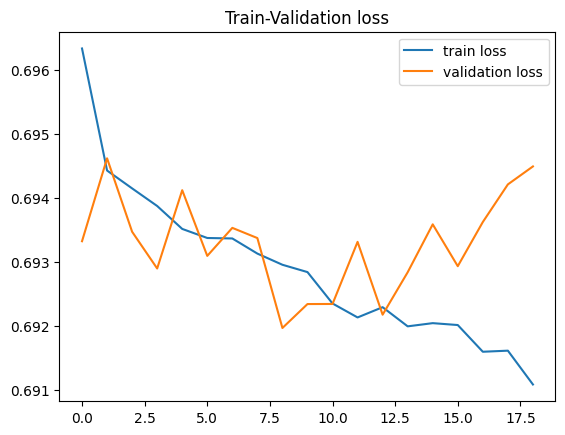

In [26]:
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
p = train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path,es_threshold=0)
torch.save(p,save_path+'.pt')

In [27]:
model = st.SingleTaskDep(model_conf,vocab,num_labels=2).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
    print('\n')
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = eval_func(model,dl_eval[task])
    for metric, value in metric_result.items():
        if metric=='accuracy':
            global_metrics[task]['acc'].append(value) 
        else:
            for g,v in value.items():
                global_metrics[task][metric][g].append(v)

        print(metric,metric_result[metric])

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).




Evaluación en el conjunto el conjunto about
recall {'female': 0.68, 'male': 0.4296875, 'average': 0.5548437500000001}
precision {'female': 0.5539714867617108, 'male': 0.5631399317406144, 'average': 0.5585557092511626}
f1 {'female': 0.6105499438832772, 'male': 0.4874446085672083, 'average': 0.5489972762252427}
accuracy 0.5573979591836735


Evaluación en el conjunto el conjunto to
recall {'female': 0.6692913385826772, 'male': 0.45742092457420924, 'average': 0.5633561315784432}
precision {'female': 0.5334728033472803, 'male': 0.5987261146496815, 'average': 0.5660994589984809}
f1 {'female': 0.5937136204889406, 'male': 0.5186206896551724, 'average': 0.5561671550720565}
accuracy 0.5593434343434344


Evaluación en el conjunto el conjunto as
recall {'female': 0.7358490566037735, 'male': 0.40404040404040403, 'average': 0.5699447303220888}
precision {'female': 0.5363457760314342, 'male': 0.6201550387596899, 'average': 0.5782504073955621}
f1 {'female': 0.6204545454545455, 'male': 0.489296636085

In [28]:
model = st.SingleTaskDep(model_conf,vocab,num_labels=2).to(device)
save_path=f'{model_name}_{encoding_type}_to2'

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6968122417503118 	 Validation loss: 0.6947017463587098 	 
  1%|          | 574/57400 [02:15<3:44:42,  4.21it/s]
Epoch 2 	 Training loss: 0.6941518933100153 	 Validation loss: 0.6931751037048082 	 
  2%|▏         | 1148/57400 [04:31<3:32:20,  4.42it/s]
Epoch 3 	 Training loss: 0.693396864763951 	 Validation loss: 0.6925261050967847 	 
  3%|▎         | 1722/57400 [06:47<3:39:44,  4.22it/s]
Epoch 4 	 Training loss: 0.6932419110673645 	 Validation loss: 0.6941831182625334 	 

1 epoch without improvement
  4%|▍         | 2296/57400 [09:02<3:38:10,  4.21it/s]
Epoch 5 	 Training loss: 0.6932793777786481 	 Validation loss: 0.6934137607024888 	 

2 epoch without improvement
  5%|▌         | 2870/57400 [11:19<3:38:34,  4.16it/s]
Epoch 6 	 Training loss: 0.6931757079599626 	 Validation loss: 0.6938715668047889 	 

3 epoch without improvement
  6%|▌         | 3444/57400 [13:35<3:29:41,  4.29it/s]
Epoch 7 	 Training loss: 0.6933316674589696 	 Validation loss: 0.6944882031

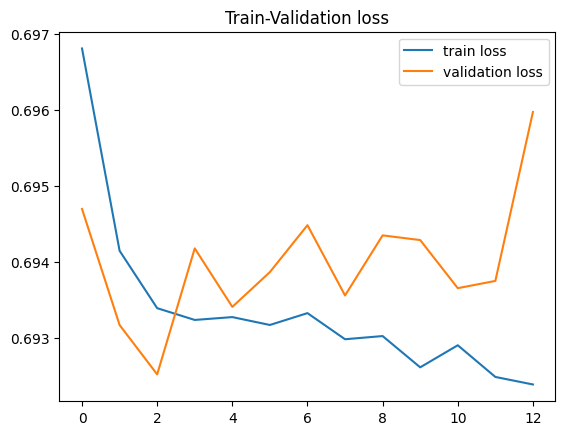

In [29]:
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
p = train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path,es_threshold=0)
torch.save(p,save_path+'.pt')

In [30]:
model = st.SingleTaskDep(model_conf,vocab,num_labels=2).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
    print('\n')
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = eval_func(model,dl_eval[task])
    for metric, value in metric_result.items():
        if metric=='accuracy':
            global_metrics[task]['acc'].append(value) 
        else:
            for g,v in value.items():
                global_metrics[task][metric][g].append(v)

        print(metric,metric_result[metric])

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).




Evaluación en el conjunto el conjunto about
recall {'female': 0.67, 'male': 0.2994791666666667, 'average': 0.48473958333333333}
precision {'female': 0.49906890130353815, 'male': 0.46558704453441296, 'average': 0.48232797291897556}
f1 {'female': 0.5720384204909285, 'male': 0.36450079239302696, 'average': 0.4682696064419777}
accuracy 0.4885204081632653


Evaluación en el conjunto el conjunto to
recall {'female': 0.7191601049868767, 'male': 0.27007299270072993, 'average': 0.4946165488438033}
precision {'female': 0.47735191637630664, 'male': 0.5091743119266054, 'average': 0.4932631141514561}
f1 {'female': 0.5738219895287958, 'male': 0.3529411764705882, 'average': 0.463381582999692}
accuracy 0.4861111111111111


Evaluación en el conjunto el conjunto as
recall {'female': 0.784366576819407, 'male': 0.25252525252525254, 'average': 0.5184459146723298}
precision {'female': 0.4957410562180579, 'male': 0.5555555555555556, 'average': 0.5256483058868068}
f1 {'female': 0.6075156576200417, 'male': 0

In [31]:
model = st.SingleTaskDep(model_conf,vocab,num_labels=2).to(device)
save_path=f'{model_name}_{encoding_type}_to3'

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6960406577545591 	 Validation loss: 0.6937325101787761 	 
  1%|          | 574/57400 [02:16<3:41:45,  4.27it/s]
Epoch 2 	 Training loss: 0.6955997053962136 	 Validation loss: 0.6921238424414295 	 
  2%|▏         | 1148/57400 [04:33<3:45:03,  4.17it/s]
Epoch 3 	 Training loss: 0.6946900932423329 	 Validation loss: 0.6939579339350684 	 

1 epoch without improvement
  3%|▎         | 1722/57400 [06:49<3:34:54,  4.32it/s]
Epoch 4 	 Training loss: 0.6951038171813048 	 Validation loss: 0.6922458945694616 	 

2 epoch without improvement
  4%|▍         | 2296/57400 [09:06<3:33:59,  4.29it/s]
Epoch 5 	 Training loss: 0.694488037027133 	 Validation loss: 0.6917622968301935 	 
  5%|▌         | 2870/57400 [11:19<3:18:31,  4.58it/s]
Epoch 6 	 Training loss: 0.6938955883531205 	 Validation loss: 0.6928067874100249 	 

1 epoch without improvement
  6%|▌         | 3444/57400 [13:31<2:47:07,  5.38it/s]
Epoch 7 	 Training loss: 0.6940790272548224 	 Validation loss: 0.6925238613

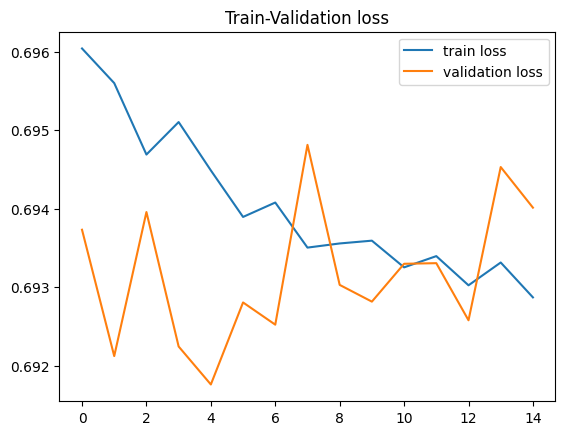

In [32]:
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
p = train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path,es_threshold=0)
torch.save(p,save_path+'.pt')

In [33]:
model = st.SingleTaskDep(model_conf,vocab,num_labels=2).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
    print('\n')
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = eval_func(model,dl_eval[task])
    for metric, value in metric_result.items():
        if metric=='accuracy':
            global_metrics[task]['acc'].append(value) 
        else:
            for g,v in value.items():
                global_metrics[task][metric][g].append(v)

        print(metric,metric_result[metric])

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).




Evaluación en el conjunto el conjunto about
recall {'female': 0.855, 'male': 0.2682291666666667, 'average': 0.5616145833333334}
precision {'female': 0.5489566613162119, 'male': 0.639751552795031, 'average': 0.5943541070556215}
f1 {'female': 0.6686217008797654, 'male': 0.37798165137614675, 'average': 0.5233016761279561}
accuracy 0.5676020408163265


Evaluación en el conjunto el conjunto to
recall {'female': 0.847769028871391, 'male': 0.29683698296836986, 'average': 0.5723030059198805}
precision {'female': 0.5277777777777778, 'male': 0.6777777777777778, 'average': 0.6027777777777779}
f1 {'female': 0.6505538771399799, 'male': 0.41285956006768193, 'average': 0.5317067186038309}
accuracy 0.5618686868686869


Evaluación en el conjunto el conjunto as
recall {'female': 0.8571428571428571, 'male': 0.20202020202020202, 'average': 0.5295815295815296}
precision {'female': 0.501577287066246, 'male': 0.6015037593984962, 'average': 0.5515405232323711}
f1 {'female': 0.6328358208955224, 'male': 0.302

Resultados finales

In [34]:
for metric in ['f1','recall','precision']:
    print(f'{metric} medio de los 3 modelos: \n')
    for task in ['about','to','as']:
        print(task.upper())
        print(f'Resultado global {metric}:',mean(global_metrics[task]['f1']['average']))
        print(f'{metric} etiqueta male:',mean(global_metrics[task]['f1']['male']))
        print(f'{metric} etiqueta female: ',mean(global_metrics[task]['f1']['female']))
        print('\n')

print(f'Accuracy medio de los 3 modelos: \n')
for task in ['about','to','as']:
    print('\n',task.upper())
    print('Resultado global accuracy:',mean(global_metrics[task]['acc']))

f1 medio de los 3 modelos: 

ABOUT
Resultado global f1: 0.5135228529317255
f1 etiqueta male: 0.4099756841121273
f1 etiqueta female:  0.6170700217513236


TO
Resultado global f1: 0.5170851522251931
f1 etiqueta male: 0.4281404753978142
f1 etiqueta female:  0.6060298290525721


AS
Resultado global f1: 0.4999637248661122
f1 etiqueta male: 0.37965877507552126
f1 etiqueta female:  0.6202686746567032


recall medio de los 3 modelos: 

ABOUT
Resultado global recall: 0.5135228529317255
recall etiqueta male: 0.4099756841121273
recall etiqueta female:  0.6170700217513236


TO
Resultado global recall: 0.5170851522251931
recall etiqueta male: 0.4281404753978142
recall etiqueta female:  0.6060298290525721


AS
Resultado global recall: 0.4999637248661122
recall etiqueta male: 0.37965877507552126
recall etiqueta female:  0.6202686746567032


precision medio de los 3 modelos: 

ABOUT
Resultado global precision: 0.5135228529317255
precision etiqueta male: 0.4099756841121273
precision etiqueta female:  0

# AS

In [35]:
learning_rate = 1e-6
num_epochs = 100

global_metrics = {'about':{'recall':{'average':[],'female':[],'male':[]},
                            'precision':{'average':[],'female':[],'male':[]},
                            'f1':{'average':[],'female':[],'male':[]},
                            'acc':[]},
                    'to':{'recall':{'average':[],'female':[],'male':[]},
                            'precision':{'average':[],'female':[],'male':[]},
                            'f1':{'average':[],'female':[],'male':[]},
                            'acc':[]},
                    'as':{'recall':{'average':[],'female':[],'male':[]},
                            'precision':{'average':[],'female':[],'male':[]},
                            'f1':{'average':[],'female':[],'male':[]},
                            'acc':[]}}

In [36]:
model = st.SingleTaskDep(model_conf,vocab,num_labels=2).to(device)
save_path=f'{model_name}_{encoding_type}_as1'


Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6973405790868952 	 Validation loss: 0.6926403379036208 	 
  1%|          | 574/57400 [02:11<3:33:46,  4.43it/s]
Epoch 2 	 Training loss: 0.6935219286003179 	 Validation loss: 0.6926709423630925 	 

1 epoch without improvement
  2%|▏         | 1148/57400 [04:22<3:29:56,  4.47it/s]
Epoch 3 	 Training loss: 0.6925479731285613 	 Validation loss: 0.6927713105234049 	 

2 epoch without improvement
  3%|▎         | 1722/57400 [06:34<2:57:04,  5.24it/s]
Epoch 4 	 Training loss: 0.6910151959711667 	 Validation loss: 0.6911930714623403 	 
  4%|▍         | 2296/57400 [08:46<3:22:42,  4.53it/s]
Epoch 5 	 Training loss: 0.6896592789826077 	 Validation loss: 0.6927778549113516 	 

1 epoch without improvement
  5%|▌         | 2870/57400 [10:57<3:26:49,  4.39it/s]
Epoch 6 	 Training loss: 0.6885958243330181 	 Validation loss: 0.6892953585770171 	 
  6%|▌         | 3444/57400 [13:08<4:35:24,  3.27it/s]
Epoch 7 	 Training loss: 0.6878588209999563 	 Validation loss: 0.690774531

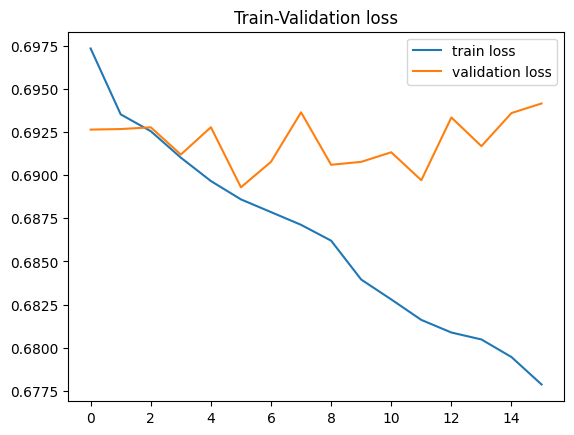

In [37]:
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
p= train.train_function(model,num_epochs,dl_train['as'],optimizer,early_stop=10,dl_val=dl_val['as'],save_path=save_path,es_threshold=0)
torch.save(p,save_path+'.pt')

In [38]:
model = st.SingleTaskDep(model_conf,vocab,num_labels=2).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
    print('\n')
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = eval_func(model,dl_eval[task])
    for metric, value in metric_result.items():
        if metric=='accuracy':
            global_metrics[task]['acc'].append(value) 
        else:
            for g,v in value.items():
                global_metrics[task][metric][g].append(v)

        print(metric,metric_result[metric])

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).




Evaluación en el conjunto el conjunto about
recall {'female': 0.855, 'male': 0.3072916666666667, 'average': 0.5811458333333334}
precision {'female': 0.5625, 'male': 0.6704545454545454, 'average': 0.6164772727272727}
f1 {'female': 0.6785714285714286, 'male': 0.42142857142857143, 'average': 0.55}
accuracy 0.5867346938775511


Evaluación en el conjunto el conjunto to
recall {'female': 0.8398950131233596, 'male': 0.30900243309002434, 'average': 0.5744487231066919}
precision {'female': 0.5298013245033113, 'male': 0.675531914893617, 'average': 0.6026666196984641}
f1 {'female': 0.6497461928934011, 'male': 0.4240400667779633, 'average': 0.5368931298356822}
accuracy 0.5643939393939394


Evaluación en el conjunto el conjunto as
recall {'female': 0.862533692722372, 'male': 0.31565656565656564, 'average': 0.5890951291894688}
precision {'female': 0.5414551607445008, 'male': 0.7102272727272727, 'average': 0.6258412167358868}
f1 {'female': 0.6652806652806654, 'male': 0.4370629370629371, 'average': 

In [39]:
model = st.SingleTaskDep(model_conf,vocab,num_labels=2).to(device)
save_path=f'{model_name}_{encoding_type}_as2'

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6968708125556388 	 Validation loss: 0.6975199964086888 	 
  1%|          | 574/57400 [02:11<3:31:36,  4.48it/s]
Epoch 2 	 Training loss: 0.6932531297206879 	 Validation loss: 0.6938642414949708 	 
  2%|▏         | 1148/57400 [04:23<3:27:50,  4.51it/s]
Epoch 3 	 Training loss: 0.6917881735110533 	 Validation loss: 0.6937257748539165 	 
  3%|▎         | 1722/57400 [06:34<3:41:55,  4.18it/s]
Epoch 4 	 Training loss: 0.6900357150242303 	 Validation loss: 0.6926242880902048 	 
  4%|▍         | 2296/57400 [08:46<3:31:05,  4.35it/s]
Epoch 5 	 Training loss: 0.6892012577854383 	 Validation loss: 0.6906959212432473 	 
  5%|▌         | 2870/57400 [10:57<3:17:28,  4.60it/s]
Epoch 6 	 Training loss: 0.6875567113273235 	 Validation loss: 0.6927277486203081 	 

1 epoch without improvement
  6%|▌         | 3444/57400 [13:08<3:13:01,  4.66it/s]
Epoch 7 	 Training loss: 0.686612958692092 	 Validation loss: 0.6932637358115892 	 

2 epoch without improvement
  7%|▋         | 40

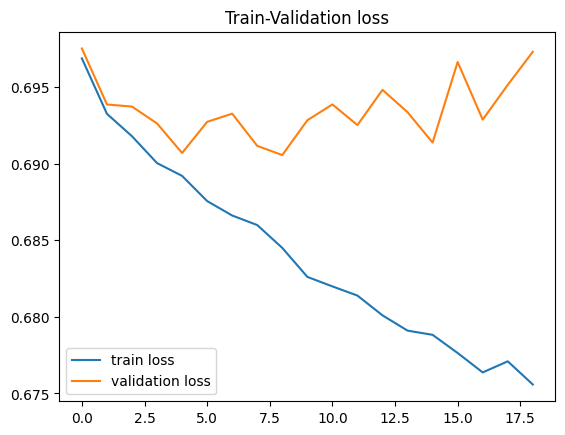

In [40]:
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
p= train.train_function(model,num_epochs,dl_train['as'],optimizer,early_stop=10,dl_val=dl_val['as'],save_path=save_path,es_threshold=0)
torch.save(p,save_path+'.pt')

In [41]:
model = st.SingleTaskDep(model_conf,vocab,num_labels=2).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
    print('\n')
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = eval_func(model,dl_eval[task])
    for metric, value in metric_result.items():
        if metric=='accuracy':
            global_metrics[task]['acc'].append(value) 
        else:
            for g,v in value.items():
                global_metrics[task][metric][g].append(v)

        print(metric,metric_result[metric])

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).




Evaluación en el conjunto el conjunto about
recall {'female': 0.6775, 'male': 0.6484375, 'average': 0.66296875}
precision {'female': 0.6674876847290641, 'male': 0.6587301587301587, 'average': 0.6631089217296113}
f1 {'female': 0.6724565756823822, 'male': 0.6535433070866142, 'average': 0.6629999413844982}
accuracy 0.6632653061224489


Evaluación en el conjunto el conjunto to
recall {'female': 0.6824146981627297, 'male': 0.6861313868613139, 'average': 0.6842730425120218}
precision {'female': 0.6683804627249358, 'male': 0.6997518610421837, 'average': 0.6840661618835597}
f1 {'female': 0.6753246753246753, 'male': 0.6928746928746929, 'average': 0.6840996840996841}
accuracy 0.6843434343434344


Evaluación en el conjunto el conjunto as
recall {'female': 0.7978436657681941, 'male': 0.6085858585858586, 'average': 0.7032147621770264}
precision {'female': 0.656319290465632, 'male': 0.7626582278481012, 'average': 0.7094887591568666}
f1 {'female': 0.7201946472019466, 'male': 0.6769662921348314, 'av

In [42]:
model = st.SingleTaskDep(model_conf,vocab,num_labels=2).to(device)
save_path=f'{model_name}_{encoding_type}_as3'

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6955857512635221 	 Validation loss: 0.6942256547636905 	 
  1%|          | 574/57400 [02:21<4:03:08,  3.90it/s]
Epoch 2 	 Training loss: 0.6955416719672571 	 Validation loss: 0.6945247155124858 	 

1 epoch without improvement
  2%|▏         | 1148/57400 [04:48<3:17:46,  4.74it/s]
Epoch 3 	 Training loss: 0.6956235788217405 	 Validation loss: 0.6946935956760988 	 

2 epoch without improvement
  3%|▎         | 1722/57400 [07:15<3:10:53,  4.86it/s]
Epoch 4 	 Training loss: 0.6961329456821136 	 Validation loss: 0.6944254636764526 	 

3 epoch without improvement
  4%|▍         | 2296/57400 [09:42<3:48:29,  4.02it/s]
Epoch 5 	 Training loss: 0.6955090222250709 	 Validation loss: 0.6943403007620472 	 

4 epoch without improvement
  5%|▌         | 2870/57400 [12:09<3:45:21,  4.03it/s]
Epoch 6 	 Training loss: 0.6956629626426962 	 Validation loss: 0.6949025190482705 	 

5 epoch without improvement
  6%|▌         | 3444/57400 [14:36<3:45:42,  3.98it/s]
Epoch 7 	 Traini

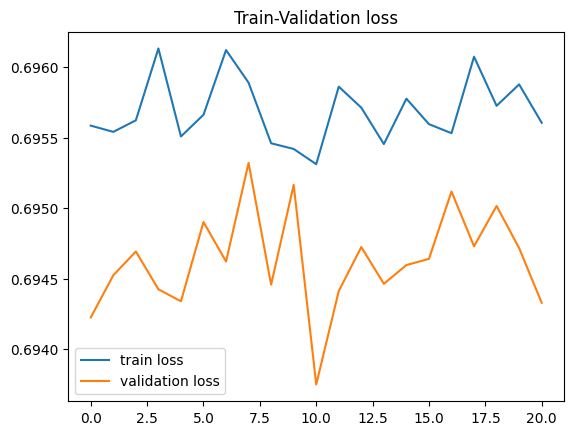

In [43]:
p= train.train_function(model,num_epochs,dl_train['as'],optimizer,early_stop=10,dl_val=dl_val['as'],save_path=save_path,es_threshold=0)
torch.save(p,save_path+'.pt')

In [44]:
model = st.SingleTaskDep(model_conf,vocab,num_labels=2).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
    print('\n')
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = eval_func(model,dl_eval[task])
    for metric, value in metric_result.items():
        if metric=='accuracy':
            global_metrics[task]['acc'].append(value) 
        else:
            for g,v in value.items():
                global_metrics[task][metric][g].append(v)

        print(metric,metric_result[metric])

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).




Evaluación en el conjunto el conjunto about
recall {'female': 0.35, 'male': 0.5078125, 'average': 0.42890625}
precision {'female': 0.425531914893617, 'male': 0.42857142857142855, 'average': 0.4270516717325228}
f1 {'female': 0.3840877914951989, 'male': 0.46483909415971386, 'average': 0.4244634428274564}
accuracy 0.4272959183673469


Evaluación en el conjunto el conjunto to
recall {'female': 0.45144356955380577, 'male': 0.45985401459854014, 'average': 0.4556487920761729}
precision {'female': 0.4365482233502538, 'male': 0.4748743718592965, 'average': 0.45571129760477513}
f1 {'female': 0.44387096774193546, 'male': 0.4672435105067985, 'average': 0.45555723912436696}
accuracy 0.45580808080808083


Evaluación en el conjunto el conjunto as
recall {'female': 0.41509433962264153, 'male': 0.5353535353535354, 'average': 0.47522393748808844}
precision {'female': 0.4556213017751479, 'male': 0.49417249417249415, 'average': 0.47489689797382106}
f1 {'female': 0.4344146685472497, 'male': 0.51393939393

Resultados finales

In [45]:
for metric in ['f1','recall','precision']:
    print(f'{metric} medio de los 3 modelos: \n')
    for task in ['about','to','as']:
        print(task.upper())
        print(f'Resultado global {metric}:',mean(global_metrics[task]['f1']['average']))
        print(f'{metric} etiqueta male:',mean(global_metrics[task]['f1']['male']))
        print(f'{metric} etiqueta female: ',mean(global_metrics[task]['f1']['female']))
        print('\n')

print(f'Accuracy medio de los 3 modelos: \n')
for task in ['about','to','as']:
    print('\n',task.upper())
    print('Resultado global accuracy:',mean(global_metrics[task]['acc']))

f1 medio de los 3 modelos: 

ABOUT
Resultado global f1: 0.5458211280706515
f1 etiqueta male: 0.5132703242249665
f1 etiqueta female:  0.5783719319163365


TO
Resultado global f1: 0.5588500176865777
f1 etiqueta male: 0.5280527567198182
f1 etiqueta female:  0.5896472786533373


AS
Resultado global f1: 0.574643100694504
f1 etiqueta male: 0.5426562077123874
f1 etiqueta female:  0.6066299936766206


recall medio de los 3 modelos: 

ABOUT
Resultado global recall: 0.5458211280706515
recall etiqueta male: 0.5132703242249665
recall etiqueta female:  0.5783719319163365


TO
Resultado global recall: 0.5588500176865777
recall etiqueta male: 0.5280527567198182
recall etiqueta female:  0.5896472786533373


AS
Resultado global recall: 0.574643100694504
recall etiqueta male: 0.5426562077123874
recall etiqueta female:  0.6066299936766206


precision medio de los 3 modelos: 

ABOUT
Resultado global precision: 0.5458211280706515
precision etiqueta male: 0.5132703242249665
precision etiqueta female:  0.578